# Multi Category Shop  -  Data Preprocessing

We will apply some Data Mining techniques to transform the data in a useful and efficient format to do our customer analysis.

In [1]:
# import modules
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import os

import random
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set()


import warnings
# current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

import calendar
import datetime
import gc

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox

from sklearn import preprocessing

# this is needed for show figure in the notebook
%matplotlib inline
color = sns.color_palette()

In [2]:
import pathlib
base_path = str(pathlib.Path().resolve())

In [3]:
# load data by combining file to obtain one single dataset

files_csv=['/archive_complete/2019-Oct.csv', 
           '/archive_complete/2019-Nov.csv',
           '/archive_complete/2019-Dec.csv',
           '/archive_complete/2020-Jan.csv',
           '/archive_complete/2020-Feb.csv',
           '/archive_complete/2020-Mar.csv',
           '/archive_complete/2020-Apr.csv']
        
# create Pandas dataframes
frame=[]
for i in range(len(files_csv)):
    print("i: ", i)
    df_i=pd.read_csv(base_path + files_csv[i])
    df_i['month']=files_csv[i][-7:-4]
    frame.append(df_i)
    print("end ", i)
data=pd.concat(frame,ignore_index=True,sort=False)

# a quick examination of the dataframe
print("The dataframe has {} rows and {} columns.\n".format(data.shape[0], data.shape[1]))
print("Shown below are the first 3 rows of the dataframe:\n")
pd.set_option('display.max_columns', 100)
display(data.head(3))

i:  0
end  0
i:  1
end  1
i:  2
end  2
i:  3
end  3
i:  4
end  4
i:  5
end  5
i:  6
end  6
The dataframe has 6848824 rows and 5 columns.

Shown below are the first 3 rows of the dataframe:



,event_time,event_type,price,user_id,month
0,2019-10-01 00:02:14 UTC,purchase,130.76,543272936,Oct
1,2019-10-01 00:04:37 UTC,purchase,642.69,551377651,Oct
2,2019-10-01 00:06:02 UTC,purchase,29.51,514591159,Oct


In [4]:
# we are interested only in events of type 'purchase', so we extract those data
purchasedata = data[data['event_type']=='purchase']

In [5]:
purchasedata.head()

,event_time,event_type,price,user_id,month
0,2019-10-01 00:02:14 UTC,purchase,130.76,543272936,Oct
1,2019-10-01 00:04:37 UTC,purchase,642.69,551377651,Oct
2,2019-10-01 00:06:02 UTC,purchase,29.51,514591159,Oct
3,2019-10-01 00:07:07 UTC,purchase,54.42,555332717,Oct
4,2019-10-01 00:09:26 UTC,purchase,189.91,524601178,Oct


# Customer Segmentation

Customer segmentation is similarly the process of dividing an organization’s customer bases into different sections or segments based on various customer attributes. The process of customer segmentation is based on the premise of finding differences among the customers’ behavior and patterns.

The major objectives and benefits behind the motivation for customer segmentation are:

- **Higher Revenue**: This is the most obvious requirement of any customer segmentation project.
- **Customer Understanding**: One of the mostly widely accepted business paradigms is “know your customer” and a segmentation of the customer base allows for a perfect dissection of this paradigm.
- **Target Marketing**: The most visible reason for customer segmentation is the ability to focus marketing efforts effectively and efficiently. If a firm knows the different segments of its customer base, it can devise better marketing campaigns which are tailor made for the segment. A good segmentation model allows for better understanding of customer requirements and hence increases the chances of the success of any marketing campaign developed by the organization.
- **Optimal Product Placement**: A good customer segmentation strategy can also help the firm with developing or offering new products, or a bundle of products together as a combined offering.
- **Finding Latent Customer Segments**: Finding out which segment of customers it might be missing to identifying untapped customer segments by focused on marketing campaigns or new business development.


**Clustering:**

The most obvious method to perform customer segmentation is using unsupervised Machine Learning methods like clustering. The method is as simple as collecting as much data about the customers as possible in the form of features or attributes and then finding out the different clusters that can be obtained from that data. Finally, we can find traits of customer segments by analyzing the characteristics of the clusters.


**RFM Model for Customer Value:**

Since our dataset is limited to the sales records, and didn´t include anothers information about our customers, we will use a RFM,*Recency, Frequency and Monetary Value, based model of customer value for finding our customer segments.

The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:
- **Recency**: The value of how recently a customer purchased at the establishment
- **Frequency**: How frequent the customer’s transactions are at the establishment
- **Monetary value**: The dollar (or pounds in our case) value of all the transactions that the customer made at the establishment

### Part I: Initial Data Preparation and Exploration

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Since the goal was to segment customers to help with marketing campaigns, to start with the simple but very effective RFM model (the RFM analysis is based on 3 factors – how recently (Recency), how often (Frequency), and how much (Monetary Value) did the customer buy) the rows and columns needed have been selected, duplicate records have been deleted, and some data type conversion have been performed.

In [6]:
#seperating timezone
purchasedata["timezone"]= purchasedata["event_time"].str.rsplit(" ", n=1,expand = True)[1]
purchasedata["event_time"]= purchasedata["event_time"].str.rsplit(" ", n=1,expand = True)[0]
purchasedata["event_time"]=pd.to_datetime(purchasedata["event_time"])

#creating date,time,hours,weekday,weeknum columns
purchasedata["date"]=purchasedata['event_time'].dt.date
purchasedata["time"]=purchasedata['event_time'].dt.time
purchasedata["hours"]=purchasedata['event_time'].dt.hour
purchasedata["weekday"]=purchasedata['event_time'].dt.weekday
purchasedata['weeknum']=purchasedata['event_time'].dt.isocalendar().week

#changing weekday to string and adding 'week_' prefix to weeknum
purchasedata['weeknum'] = 'week_' + purchasedata['weeknum'].astype(str)
purchasedata['weekday']= purchasedata['weekday'].replace({0:'Mon',1:'Tues',2:'Wed',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'})

In [7]:
# data preparation

# step 1: removing samples with negative price
purchasedata = purchasedata[purchasedata['price'] >= 0]

# step 2: drop duplicates
purchasedata = purchasedata.drop_duplicates()

# step 2: drop "category_code", "brand", "product_id", "category_id", and "user_session"
# purchasedata = purchasedata.drop(columns=['category_code','brand','product_id','category_id','user_session'])

# step 4: convert "event_time" to DateTime format
purchasedata['event_time'] = pd.to_datetime(purchasedata['event_time'], infer_datetime_format=True)

nullcolumns = purchasedata.isnull().sum()
nullnumbers = len(nullcolumns[nullcolumns!=0])
print("After data selection and cleansing, the dataframe has {} rows, {} columns, and {} null value.\n".format(purchasedata.shape[0], purchasedata.shape[1],nullnumbers))
print("Shown below are the first 3 rows of the cleaned dataframe:\n")
display(purchasedata.head(3))

After data selection and cleansing, the dataframe has 6697266 rows, 11 columns, and 0 null value.

Shown below are the first 3 rows of the cleaned dataframe:



,event_time,event_type,price,user_id,month,timezone,date,time,hours,weekday,weeknum
0,2019-10-01 00:02:14,purchase,130.76,543272936,Oct,UTC,2019-10-01,00:02:14,0,Tues,week_40
1,2019-10-01 00:04:37,purchase,642.69,551377651,Oct,UTC,2019-10-01,00:04:37,0,Tues,week_40
2,2019-10-01 00:06:02,purchase,29.51,514591159,Oct,UTC,2019-10-01,00:06:02,0,Tues,week_40


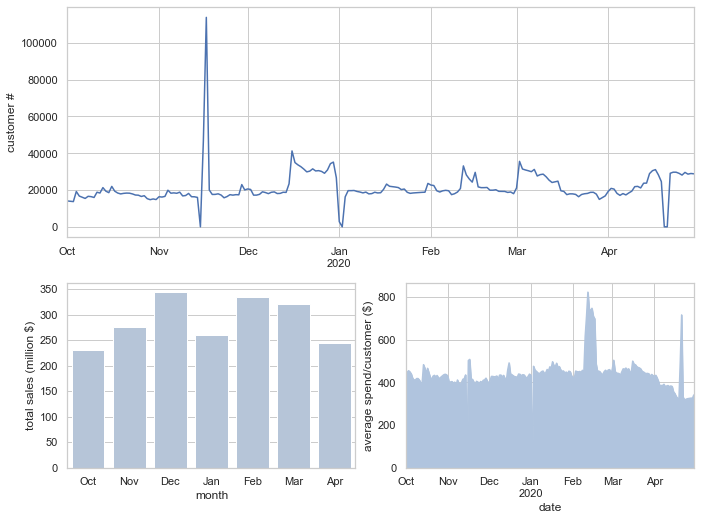

In [22]:
# initial data exploration

plt.figure(figsize=(10,8))

# plot the number of customers each day 
plt.axes([0.08, 0.4, 0.87, 0.4])
purchasedata_n_user = purchasedata.resample("D",on='event_time')['user_id'].nunique()
purchasedata_n_user.plot(kind='line')
plt.xlabel('')
plt.ylabel('customer #')

# plot total sales/month 
plt.axes([0.08,0,0.4,0.32])
a=purchasedata.resample('M',on='event_time')['price'].sum().to_frame()
a['month']=['Oct','Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
a['price']=a['price']/1000000
sns.barplot(x='month',y='price',data=a,color="lightsteelblue")
plt.xlabel('month')
plt.ylabel('total sales (million $)')

# plot average spend/customer
plt.axes([0.55,0,0.4,0.32])
purchasedata_p_day = purchasedata.resample('D',on='event_time')['price'].sum()
purchasedata_spent = purchasedata_p_day/purchasedata_n_user
purchasedata_spent.plot(kind='area',color="lightsteelblue")
plt.xlabel('date')
plt.ylabel('average spend/customer ($)');

#### Feature generation

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Next, I grouped the data by user_id, and calculated each customer’s Recency (how many days had it been since the customer’s last purchase), Frequency (how often had the customer made a purchase), and Monetary Value(how much did the customer spend).

In [9]:
# group the data by "user_id", and calcualte each customer's recency, frequency, and monetary value

# step 1: calculate "Recency", set Feb 2020 as the reference month, and use "month" as the unit
# d={"Oct":4,"Nov":3,"Dec":2,"Jan":1,"Feb":0}
# df_sales.loc[:,'Recency']=df_sales['month'].map(d)
# df_R=df_sales.groupby('user_id')['Recency'].min().reset_index().rename(columns={"0":"Recency"})

# step 1: calculate "Recency", set max event_time + 1 day as reference day and calculate recency
# refrence_date = datetime.datetime.strptime(purchasedata['event_time'].max(), '%Y-%m-%d %H:%M:%S') + datetime.timedelta(days = 1)
refrence_date = purchasedata['event_time'].max() + datetime.timedelta(days = 1)
print('Reference Date:', refrence_date)
purchasedata['days_since_last_purchase'] = (refrence_date - purchasedata['event_time']).astype('timedelta64[D]')
df_recency = purchasedata[['user_id', 'days_since_last_purchase']].groupby("user_id").min().reset_index()
df_recency.rename(columns={'days_since_last_purchase': 'Recency'}, inplace=True)
#customer_history_df.describe().transpose()
print("RECENCY ------")
print(df_recency.head())

# step 2: calculate "Frequency"
df_frequency = purchasedata.groupby('user_id')['event_type'].count().reset_index().rename(columns={"event_type": "Frequency"})
print("FREQUENCY ------")
print(df_frequency.head())

# step 3: calculate "Monetary"
df_monetary = purchasedata.groupby('user_id')['price'].sum().reset_index().rename(columns={"price": "Monetary"})
print("MONETARY VALUE ------")
print(df_monetary.head())

Reference Date: 2020-05-01 23:59:36
RECENCY ------
     user_id  Recency
0   96369466     12.0
1  101875240    106.0
2  107620212     92.0
3  128029678     23.0
4  128968633     55.0
FREQUENCY ------
     user_id  Frequency
0   96369466          1
1  101875240          1
2  107620212          1
3  128029678          3
4  128968633          4
MONETARY VALUE ------
     user_id  Monetary
0   96369466     50.71
1  101875240    184.52
2  107620212    244.28
3  128029678    569.89
4  128968633    714.01


In [10]:
# step 4: merge "Recency", "Frequency", and "Monetary"
df_RF = pd.merge(df_recency, df_frequency, on='user_id')
df_RFM = pd.merge(df_RF, df_monetary, on='user_id')

# # step 5: remove outliers before K-Means clustering
# conditions = np.abs(stats.zscore(df_RFM.loc[:,['Recency','Frequency','Monetary']]) < 3).all(axis=1)
# df_RFM2=df_RFM.loc[conditions,:]

df_RFM.head(3)

,user_id,Recency,Frequency,Monetary
0,96369466,12.0,1,50.71
1,101875240,106.0,1,184.52
2,107620212,92.0,1,244.28


In [11]:
df_RFM.describe()

,user_id,Recency,Frequency,Monetary
count,2.064899e+06,2.064899e+06,2.064899e+06,2.064899e+06
mean,5.652546e+08,8.959922e+01,3.243387e+00,9.737000e+02
std,4.047368e+07,6.203335e+01,7.909233e+00,3.583965e+03
min,9.636947e+07,1.000000e+00,1.000000e+00,3.100000e-01
25%,5.265437e+08,3.400000e+01,1.000000e+00,1.392600e+02
50%,5.609019e+08,8.100000e+01,2.000000e+00,3.170100e+02
75%,5.971770e+08,1.390000e+02,3.000000e+00,8.443000e+02
max,6.497740e+08,2.130000e+02,2.119000e+03,7.883386e+05


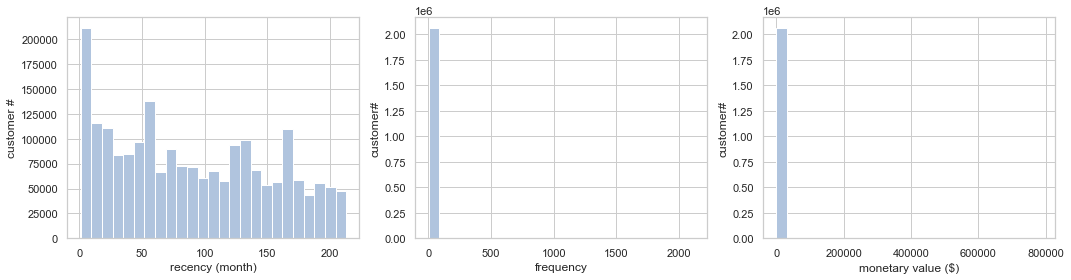

In [12]:
# visualize the distribution of "Recency", "Frequency", and "Monetary"
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,4))

# plot "Recency"
ax1.hist(df_RFM['Recency'],bins=25,color='lightsteelblue')
# ax1.set_xticks(np.arange(0,5,1))
ax1.set_xlabel('recency (month)')
ax1.set_ylabel('customer #')

# plot "Frequency"
ax2.hist(df_RFM['Frequency'],bins=25,color='lightsteelblue')
ax2.set_xlabel('frequency')
ax2.set_ylabel('customer#')

# plot "Monetary"
ax3.hist(df_RFM['Monetary'],bins=25,color='lightsteelblue')
ax3.set_xlabel('monetary value ($)')
ax3.set_ylabel('customer#')

plt.tight_layout()

#### Visualization of distributions

In [13]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center', fontsize=20)
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f} )'.format(data.skew(), data.kurt()), loc='center', fontsize=20)

    plt.tight_layout()
    plt.show()

RECENCY:

In [14]:
df_recency.describe()

,user_id,Recency
count,2.064899e+06,2.064899e+06
mean,5.652546e+08,8.959922e+01
std,4.047368e+07,6.203335e+01
min,9.636947e+07,1.000000e+00
25%,5.265437e+08,3.400000e+01
50%,5.609019e+08,8.100000e+01
75%,5.971770e+08,1.390000e+02
max,6.497740e+08,2.130000e+02


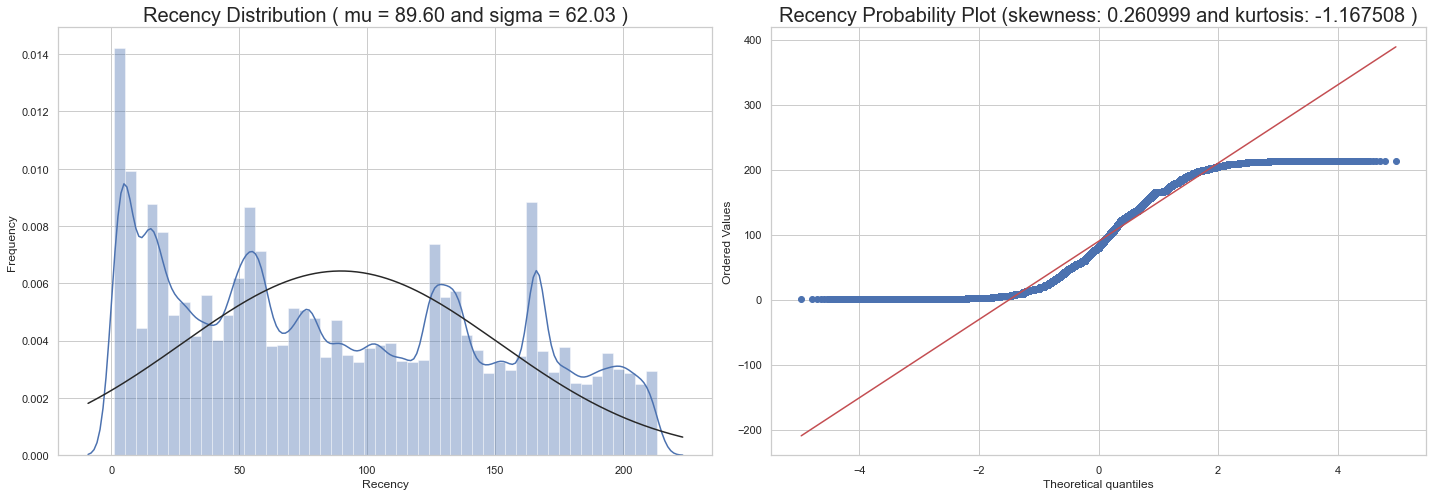

In [15]:
QQ_plot(df_recency['Recency'], 'Recency')

FREQUENCY:

In [16]:
df_frequency.describe()

,user_id,Frequency
count,2.064899e+06,2.064899e+06
mean,5.652546e+08,3.243387e+00
std,4.047368e+07,7.909233e+00
min,9.636947e+07,1.000000e+00
25%,5.265437e+08,1.000000e+00
50%,5.609019e+08,2.000000e+00
75%,5.971770e+08,3.000000e+00
max,6.497740e+08,2.119000e+03


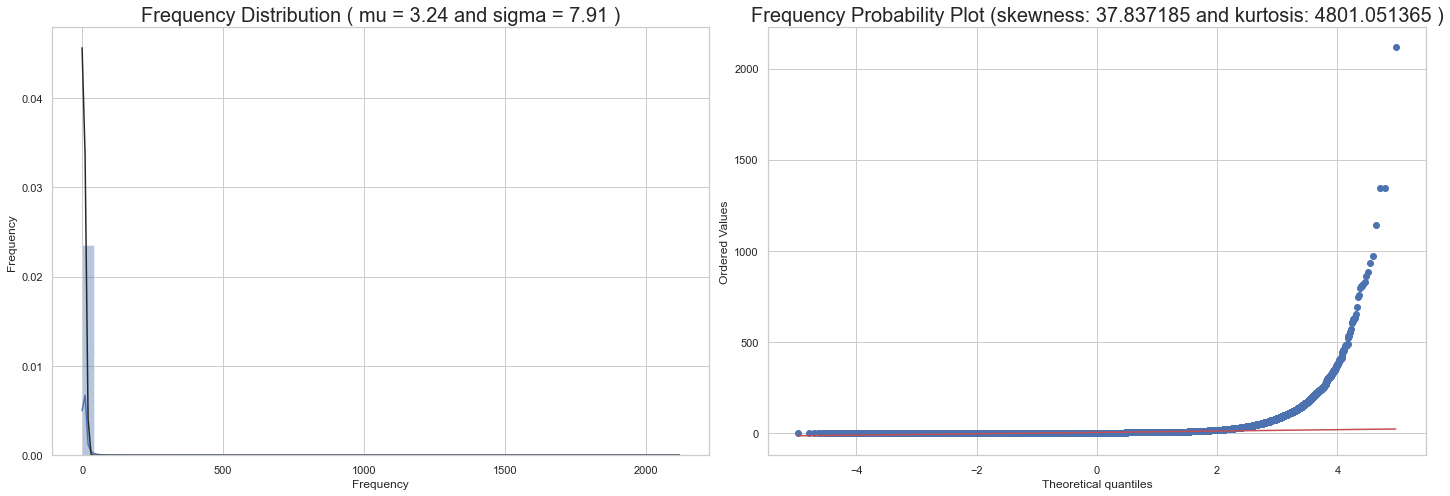

In [17]:
QQ_plot(df_frequency['Frequency'], 'Frequency')

MONETARY VALUE:

In [18]:
df_monetary.describe()

,user_id,Monetary
count,2.064899e+06,2.064899e+06
mean,5.652546e+08,9.737000e+02
std,4.047368e+07,3.583965e+03
min,9.636947e+07,3.100000e-01
25%,5.265437e+08,1.392600e+02
50%,5.609019e+08,3.170100e+02
75%,5.971770e+08,8.443000e+02
max,6.497740e+08,7.883386e+05


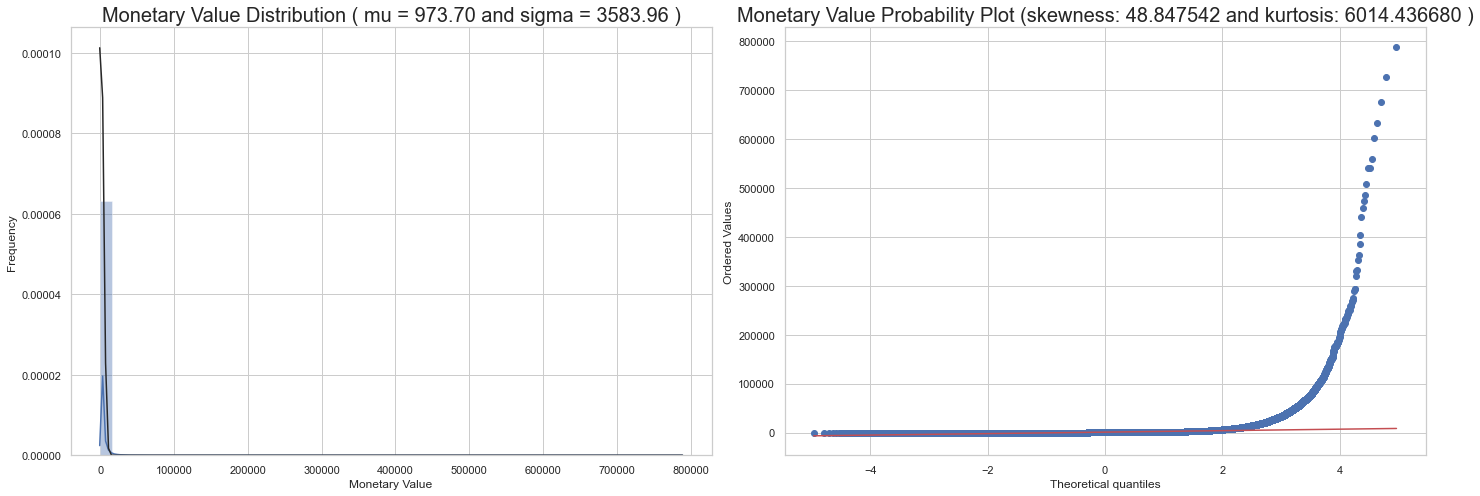

In [19]:
QQ_plot(df_monetary['Monetary'], 'Monetary Value')

RFM:

In [20]:
df_RFM.describe()

,user_id,Recency,Frequency,Monetary
count,2.064899e+06,2.064899e+06,2.064899e+06,2.064899e+06
mean,5.652546e+08,8.959922e+01,3.243387e+00,9.737000e+02
std,4.047368e+07,6.203335e+01,7.909233e+00,3.583965e+03
min,9.636947e+07,1.000000e+00,1.000000e+00,3.100000e-01
25%,5.265437e+08,3.400000e+01,1.000000e+00,1.392600e+02
50%,5.609019e+08,8.100000e+01,2.000000e+00,3.170100e+02
75%,5.971770e+08,1.390000e+02,3.000000e+00,8.443000e+02
max,6.497740e+08,2.130000e+02,2.119000e+03,7.883386e+05


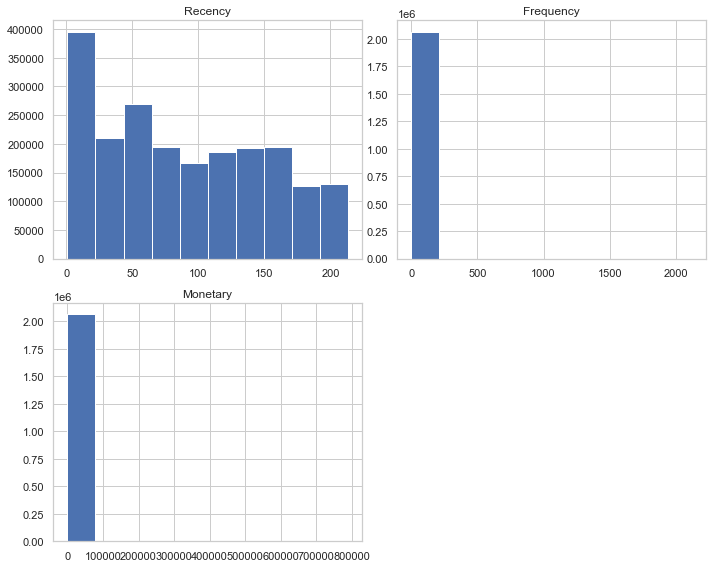

In [21]:
# Visualize distribution of each feature
tmp = df_RFM.drop('user_id', axis=1)
tmp.hist(figsize=(10,8))
plt.tight_layout();

We can see that many customer made a single order and that a littel fraction of them spent many money. Recency has a peak that correspond to the 17th of november that is the day with the highest amount of orders.

## Features scaling 

In [23]:
feature_vector = ['Recency', 'Frequency', 'Monetary']
tmp = df_RFM.drop('user_id', axis=1)
X_subset = tmp[feature_vector] #.as_matrix()
X_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2064899 entries, 0 to 2064898
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Recency    float64
 1   Frequency  int64  
 2   Monetary   float64
dtypes: float64(2), int64(1)
memory usage: 63.0 MB


In [24]:
X_subset.head()

,Recency,Frequency,Monetary
0,12.0,1,50.71
1,106.0,1,184.52
2,92.0,1,244.28
3,23.0,3,569.89
4,55.0,4,714.01


In [25]:
X_scaled = preprocessing.StandardScaler().fit_transform(X_subset)

In [26]:
# show standardized data properties
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,2064899.0,1.034666e-13,1.0,-1.428252,-0.896280,-0.138623,0.796359,1.989266
Frequency,2064899.0,1.159805e-14,1.0,-0.283642,-0.283642,-0.157207,-0.030772,267.504708
Monetary,2064899.0,4.756049e-15,1.0,-0.271596,-0.232826,-0.183230,-0.036105,219.691060


In [27]:
customer_data_scaled = pd.DataFrame(X_scaled, columns=X_subset.columns)
customer_data_scaled.head()

,Recency,Frequency,Monetary
0,-1.250928,-0.283642,-0.257533
1,0.264387,-0.283642,-0.220198
2,0.038702,-0.283642,-0.203523
3,-1.073604,-0.030772,-0.112671
4,-0.557752,0.095662,-0.072459


In [28]:
# Plot the distribution of data

# fig = plt.figure(figsize=(20,14))
# f1 = fig.add_subplot(221); sns.regplot(x='recency', y='monetary_value', data=customer_history_df)
# f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='monetary_value', data=customer_history_df)

# fig = plt.figure(figsize=(15, 10))
# ax = fig.add_subplot(111, projection='3d')

# xs = customer_data_scaled.recency
# ys = customer_data_scaled.frequency
# zs = customer_data_scaled.monetary_value
# ax.scatter(xs, ys, zs, s=5)

# ax.set_xlabel('Recency')
# ax.set_ylabel('Frequency')
# ax.set_zlabel('Monetary Value')

# plt.show()

In [29]:
# log scaling data

tmp_log = tmp.copy()

tmp_log['Recency'] += 1.0
tmp_log['Frequency'] += 1.0
tmp_log['Monetary'] += 1.0

tmp_log['Recency'] = np.log(tmp_log['Recency'])
tmp_log['Frequency'] = np.log(tmp_log['Frequency'])
tmp_log['Monetary'] = np.log(tmp_log['Monetary'])
# feature_vector = ['totalprice_log', 'recency_log','frequency_log']
feature_vector = ['Recency', 'Frequency', 'Monetary']
X_subset_log = tmp_log[feature_vector] #.as_matrix()
X_subset_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2064899 entries, 0 to 2064898
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Recency    float64
 1   Frequency  float64
 2   Monetary   float64
dtypes: float64(3)
memory usage: 63.0 MB


In [30]:
X_scaled_log = preprocessing.StandardScaler().fit_transform(X_subset_log)

In [31]:
# show log scaled data properties
pd.DataFrame(X_scaled_log, columns=X_subset_log.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,2064899.0,-5.482345e-14,1.0,-3.068747,-0.487699,0.280042,0.762419,1.145071
Frequency,2064899.0,-4.954444e-13,1.0,-0.738370,-0.738370,-0.077782,0.390912,10.610745
Monetary,2064899.0,-1.752596e-15,1.0,-3.914664,-0.608968,-0.029956,0.661538,5.498270


In [32]:
customer_data_scaled_log = pd.DataFrame(X_scaled_log, columns=X_subset_log.columns)
customer_data_scaled_log.head()

,Recency,Frequency,Monetary
0,-1.380811,-0.738370,-1.314777
1,0.520011,-0.738370,-0.411152
2,0.393557,-0.738370,-0.213638
3,-0.827932,0.390912,0.383914
4,-0.063864,0.754460,0.543134


In [33]:
# Plot the data

# fig = plt.figure(figsize=(20,14))
# f1 = fig.add_subplot(221); sns.regplot(x='recency', y='monetary_value', data=customer_history_df_log)
# f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='monetary_value', data=customer_history_df_log)

# fig = plt.figure(figsize=(15, 10))
# ax = fig.add_subplot(111, projection='3d')

# xs = customer_data_scaled_log.recency
# ys = customer_data_scaled_log.frequency
# zs = customer_data_scaled_log.monetary_value
# ax.scatter(xs, ys, zs, s=5)

# ax.set_xlabel('Recency')
# ax.set_ylabel('Frequency')
# ax.set_zlabel('Monetary Value')

# plt.show()

### Save the files

In [34]:
customer_data_scaled_log.to_csv(path_or_buf= base_path+"/customer_data_log_scaled.csv", 
                                encoding = 'ISO-8859-1', 
                                index = False)

In [35]:
customer_data_scaled.to_csv(path_or_buf= base_path+"/customer_data.csv", 
                             encoding = 'ISO-8859-1', 
                             index = False)